In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np

experiments = ["test"]
baselines = ['IQN', 'Rainbow', 'REM', 'DQN (Adam)', 'C51', 'DQN (Nature)']
games = ["Breakout", "Asterix"]
ks = [1]
seeds = [1]
plot_std = True
selected_epochs = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [18]:
from idqn.utils.baselines_scores import get_baselines_scores

idqn_scores = {}
for experiment in experiments:
    for k in ks:
        idqn_scores[f"{experiment}_{k}"] = {}
        for game in games:
            idqn_scores[f"{experiment}_{k}"][game] = np.zeros((200, len(seeds))) * np.nan
            for idx_seed, seed in enumerate(seeds):
                idqn_scores[f"{experiment}_{k}"][game][:, idx_seed] = np.load(f"figures/{experiment}/{game}/iDQN/{k}_J_{seed}.npy")

baselines_scores = get_baselines_scores(baselines, games)

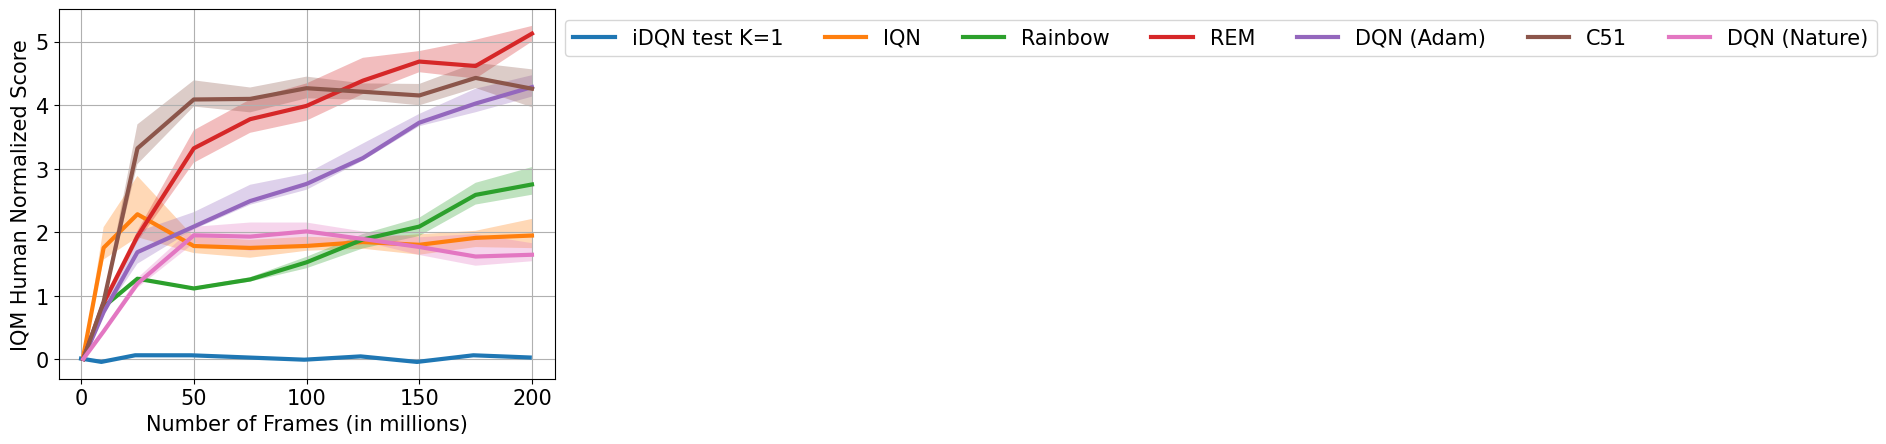

In [19]:
import matplotlib.pyplot as plt
from idqn.utils.process_scores import compute_iqm_and_confidence_interval

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)


for experiment in experiments:
    for k in ks:
        iqms, iqms_confidence_interval = compute_iqm_and_confidence_interval(idqn_scores[f"{experiment}_{k}"], selected_epochs)
        plt.plot(selected_epochs, iqms, label=f"iDQN {experiment} K={k}")
        if plot_std:
            plt.fill_between(selected_epochs, iqms_confidence_interval[0, :], iqms_confidence_interval[1, :], alpha=0.3)

for baseline in baselines:
    iqms, iqms_confidence_interval = compute_iqm_and_confidence_interval(baselines_scores[baseline], selected_epochs)
    plt.plot(selected_epochs + 1, iqms, label=baseline)
    if plot_std:
        plt.fill_between(selected_epochs + 1, iqms_confidence_interval[0, :], iqms_confidence_interval[1, :], alpha=0.3)

plt.grid()
plt.xlabel("Number of Frames (in millions)")
plt.ylabel("IQM Human Normalized Score")
if len(games) == 1:
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title(games[0])
    _ = plt.savefig(f"figures/{experiments[0]}/{games[0]}/J.pdf", bbox_inches='tight')
else:
    plt.legend(ncols=len(baselines) + len(experiments) + len(ks), bbox_to_anchor=[1, 1])
    _ = plt.savefig(f"figures/{experiments[0]}/J.pdf", bbox_inches='tight')